In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
# 디렉토리 설정
unlabeled_data_dir = r"./injectionmoding_dataset/injectionmoding_dataset_unlabeled.csv"
unlabeled_df = pd.read_csv(unlabeled_data_dir)

labeled_data_dir = r"./injectionmoding_dataset/경진대회용 사출성형기 데이터셋_labeled.csv"
labeled_df = pd.read_csv(labeled_data_dir)

In [3]:
# 디스플레이 옵션 설정
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.unicode.east_asian_width', True)

In [4]:
def useless_data_drop(dataframe):
    # 중복 데이터 제거
    dataframe = dataframe.drop_duplicates()
    # 1차 분석 후 불필요 데이터 제거
    dataframe.drop("_id", axis=1, inplace=True)
    dataframe.drop("PART_FACT_PLAN_DATE", axis=1, inplace=True)
    # 분석모델에 쓸모 없는 데이터 제거
    for column, value in dataframe.std().iteritems():
        if value == 0:
            dataframe.drop(f"{column}", axis=1, inplace=True)
    # Datetime으로 변경
    dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)
    return dataframe

In [5]:
# 필요없는 데이터 제거
unlabeled_df = useless_data_drop(unlabeled_df)
unlabeled_df.drop("Unnamed: 0", axis=1, inplace=True)


labeled_df = useless_data_drop(labeled_df)

C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [6]:
# 장비, 제품 별 분류 함수
def div_pa_eq(dataframe, part_name, equip_name):
    part_name_filter = dataframe["PART_NAME"].str.contains(part_name)
    equip_name_filter = dataframe["EQUIP_NAME"].str.contains(equip_name)

    return dataframe[part_name_filter & equip_name_filter]

In [7]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
ERR_filter = unlabeled_df["ERR_FACT_QTY"] <= 5  # 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
SOP_filter = unlabeled_df["Switch_Over_Position"] == 0  # Switch_Over_Position 0인지 아닌지에 따라 공정이 달라지는듯

CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter & ERR_filter & SOP_filter]

In [8]:
# 이상치 측정 함수
def outlier(x):
    Q1 = x.quantile(1/4)
    Q3 = x.quantile(3/4)
    IQR = Q3 - Q1
    LL = Q1 - (1.5*IQR)
    UU = Q3 + (1.5*IQR)
    outlier = (x < LL) | (x > UU)
    return outlier

# unlabeled데이터 분석 후 사용 안하는 데이터 제거

In [9]:
# 종속 변수 제거
CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2
unlabeled_CN7_650T_train = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)

unlabeled_CN7_650T_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6572 entries, 303003 to 777220
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              6572 non-null   float64
 1   Plasticizing_Time         6572 non-null   float64
 2   Cushion_Position          6572 non-null   float64
 3   Plasticizing_Position     6572 non-null   float64
 4   Max_Injection_Speed       6572 non-null   float64
 5   Max_Screw_RPM             6572 non-null   float64
 6   Average_Screw_RPM         6572 non-null   float64
 7   Max_Injection_Pressure    6572 non-null   float64
 8   Max_Switch_Over_Pressure  6572 non-null   float64
 9   Average_Back_Pressure     6572 non-null   float64
 10  Barrel_Temperature_2      6572 non-null   float64
 11  Packing_Time              6572 non-null   float64
 12  Avg_Mold_Temperature      6572 non-null   float64
dtypes: float64(13)
memory usage: 718.8 KB


C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\break\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# labeled데이터 분석 후 사용 안하는 데이터 제거

In [10]:
# CN7_우진650톤 데이터 추출
CN7_filter = labeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = labeled_df["EQUIP_NAME"].str.contains("650")

labeled_df = labeled_df[CN7_filter & Eq650_filter]

# # Pass or Fail, Reason 데이터를 더미 변수로 변환
# label_encoder = preprocessing.LabelEncoder()
# onehot_encoder = preprocessing.OneHotEncoder()
# onehot_Reason = label_encoder.fit_transform(labeled_df["Reason"])
# labeled_df["Reason"] = onehot_Reason

# 데이터 분석 후 종속 변수 제거
labeled_df["Packing_Time"] = labeled_df["Injection_Time"] - labeled_df["Filling_Time"]
labeled_df["Avg_Mold_Temperature"] = (labeled_df["Mold_Temperature_3"] + labeled_df["Mold_Temperature_4"])/2
labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)

# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

labeled_df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 5157
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              3946 non-null   float64
 1   Plasticizing_Time         3946 non-null   float64
 2   Cushion_Position          3946 non-null   float64
 3   Plasticizing_Position     3946 non-null   float64
 4   Max_Injection_Speed       3946 non-null   float64
 5   Max_Screw_RPM             3946 non-null   float64
 6   Average_Screw_RPM         3946 non-null   float64
 7   Max_Injection_Pressure    3946 non-null   float64
 8   Max_Switch_Over_Pressure  3946 non-null   float64
 9   Average_Back_Pressure     3946 non-null   float64
 10  Barrel_Temperature_2      3946 non-null   float64
 11  Packing_Time              3946 non-null   float64
 12  Avg_Mold_Temperature      3946 non-null   float64
dtypes: float64(13)
memory usage: 431.6 KB


C:\Users\break\anaconda3\envs\keras\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# 각 데이터 히스토그램 시각화

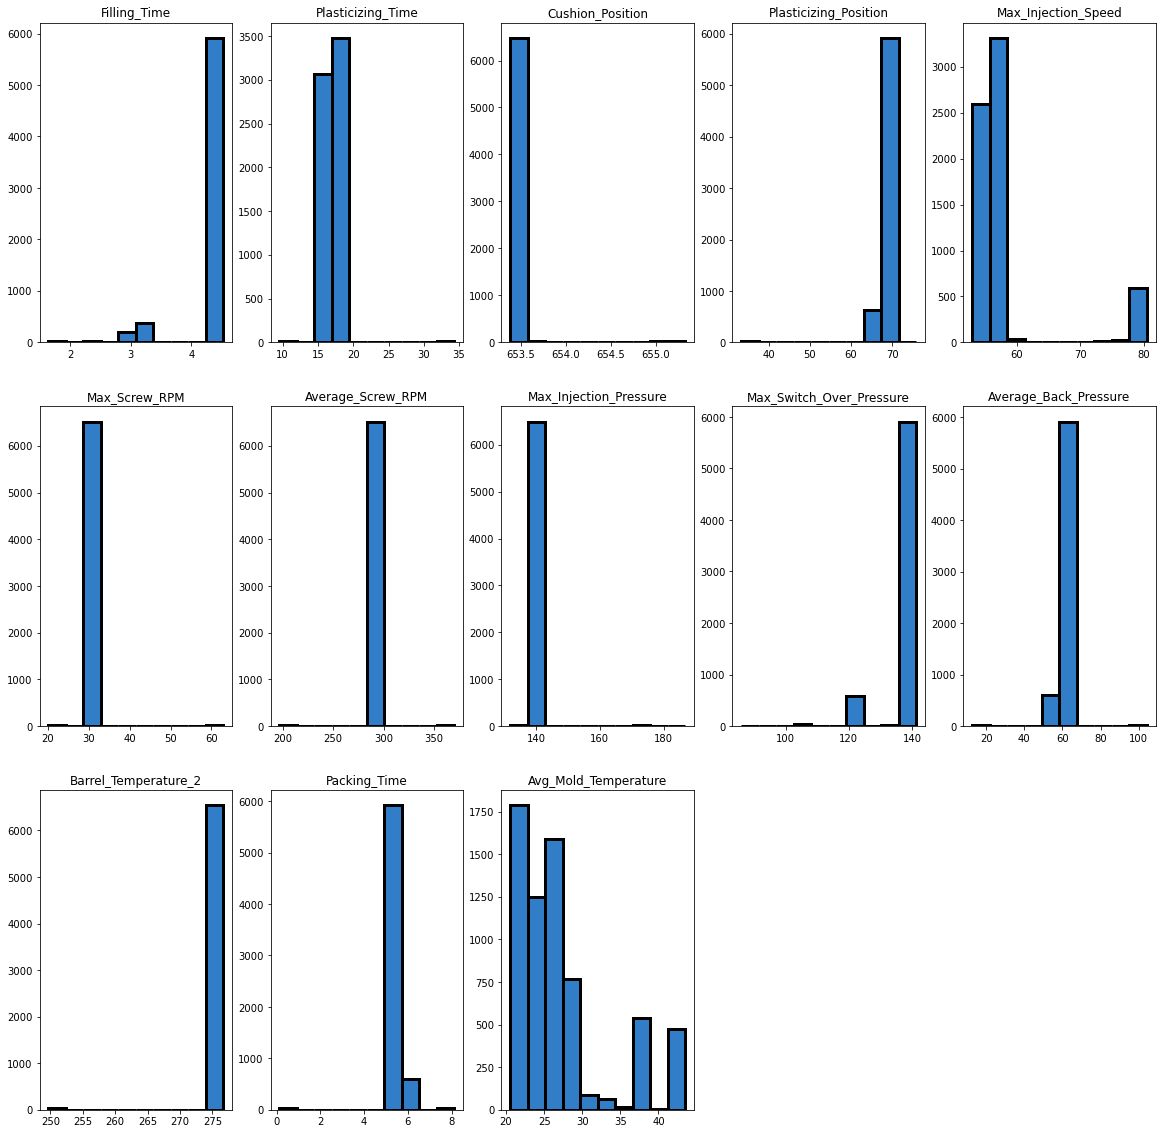

In [11]:
# unlabele데이터 히스토그램 시각화

data = unlabeled_CN7_650T_train
for index, value in enumerate(data):
    sub = plt.subplot(3, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

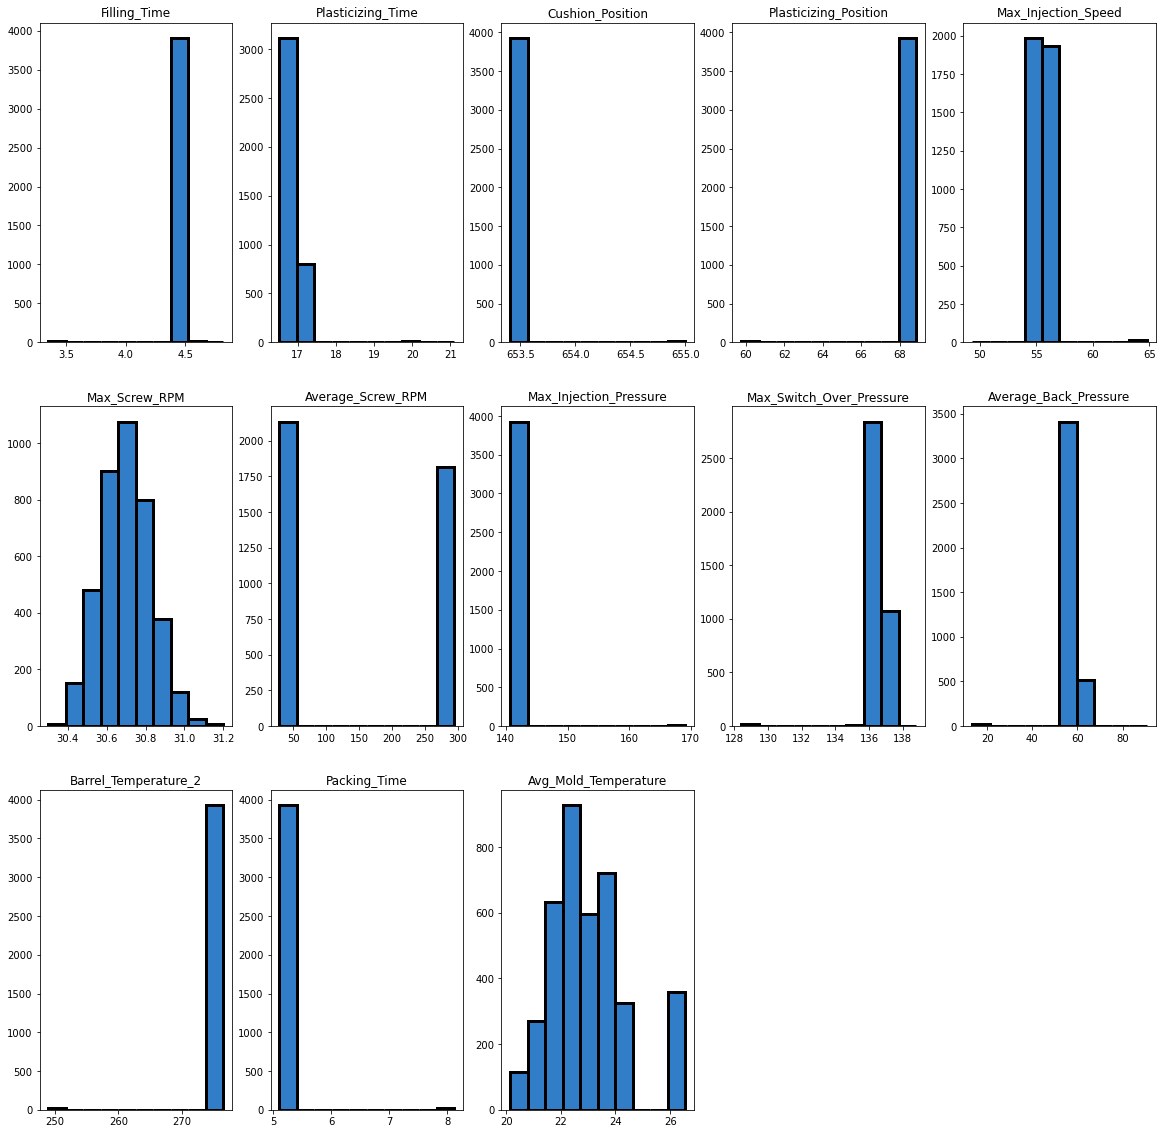

In [12]:
# labele데이터 히스토그램 시각화

data = labeled_df_Y
for index, value in enumerate(data):
    sub = plt.subplot(3, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [13]:
# label+unlabeled train 데이터
train_df = pd.concat([unlabeled_CN7_650T_train, labeled_df_Y], ignore_index=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10518 entries, 0 to 10517
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              10518 non-null  float64
 1   Plasticizing_Time         10518 non-null  float64
 2   Cushion_Position          10518 non-null  float64
 3   Plasticizing_Position     10518 non-null  float64
 4   Max_Injection_Speed       10518 non-null  float64
 5   Max_Screw_RPM             10518 non-null  float64
 6   Average_Screw_RPM         10518 non-null  float64
 7   Max_Injection_Pressure    10518 non-null  float64
 8   Max_Switch_Over_Pressure  10518 non-null  float64
 9   Average_Back_Pressure     10518 non-null  float64
 10  Barrel_Temperature_2      10518 non-null  float64
 11  Packing_Time              10518 non-null  float64
 12  Avg_Mold_Temperature      10518 non-null  float64
dtypes: float64(13)
memory usage: 1.0 MB


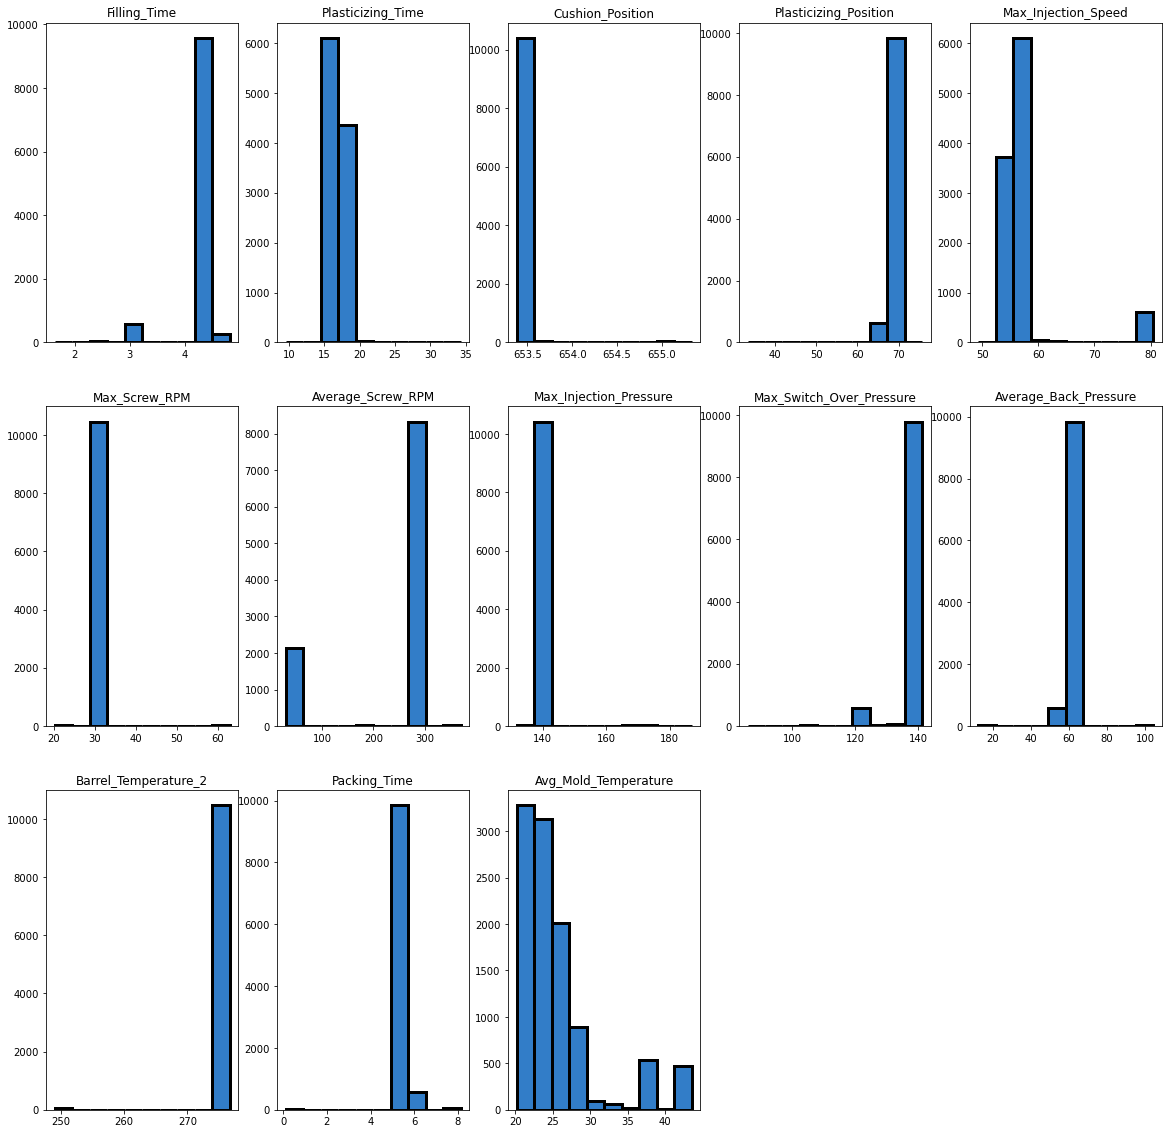

In [14]:
# train 데이터 히스토그램 시각화

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(3, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# DAE 적용

In [15]:
# outlier 제거
outlier_result = train_df.apply(outlier)
train_df = train_df[outlier_result.sum(axis=1) < 2]

# 데이터 정규화
scaler = preprocessing.MinMaxScaler()
train_df = scaler.fit_transform(train_df)
labeled_df_N_test = scaler.fit_transform(labeled_df_N_test)

# 학습, 평가데이터 분리
train_df, test_df_Y = train_test_split(train_df, train_size=0.8, test_size=0.2)

In [79]:
def denoising_autoencoder(data):
    data_input = Input((data.shape[1],))
    noise = Dropout(0.6)(data_input)
    h1 = Dense(10)(noise)
    h1 = BatchNormalization()(h1)
    h1 = Activation('swish')(h1)
    h2 = Dense(5)(h1)
    h2 = BatchNormalization()(h2)
    h2 = Activation('swish')(h2)
    h3 = Dense(3)(h2)
    h3 = BatchNormalization()(h3)
    h3 = Activation('swish')(h3)
    h4 = Dense(5)(h3)
    h4 = BatchNormalization()(h4)
    h4 = Activation('swish')(h4)
    h5 = Dense(10)(h4)
    h5 = BatchNormalization()(h5)
    h5 = Activation('swish')(h5)
    h6 = Dense(data.shape[1])(h5)
    h6 = BatchNormalization()(h6)
    out_put = Activation('swish')(h6)
    
    DAE = Model(data_input, out_put)
    DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    DAE.summary()
    return DAE
#     # Encoder
#     dropout_encoder = Sequential([Dropout(0.3), Dense(10, activation="relu"), Dense(5, activation="relu"), Dense(3, activation="relu")])
#     # Decoder
#     dropout_decoder = Sequential([Dense(5, activation="relu", input_shape=[3]), Dense(10, activation="relu", input_shape=[5]), Dense(data.shape[1], activation="relu")])
#     DAE = Sequential([dropout_encoder, dropout_decoder])
#     DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#     return DAE

In [80]:
# DAE 적용
DAE = denoising_autoencoder(train_df)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 10)                140       
_________________________________________________________________
batch_normalization_36 (Batc (None, 10)                40        
_________________________________________________________________
activation_36 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 5)                 55        
_________________________________________________________________
batch_normalization_37 (Batc (None, 5)                 20  

In [81]:
# 모델 훈련
history = DAE.fit(train_df, train_df, batch_size=100, epochs=500, validation_split=0.2)

Epoch 1/500
57/57 [==============================] - 2s 6ms/step - loss: 0.3801 - accuracy: 0.0211 - val_loss: 0.2682 - val_accuracy: 0.0014
Epoch 2/500
57/57 [==============================] - 0s 3ms/step - loss: 0.2780 - accuracy: 0.0360 - val_loss: 0.2163 - val_accuracy: 0.0014
Epoch 3/500
57/57 [==============================] - 0s 3ms/step - loss: 0.2255 - accuracy: 0.1074 - val_loss: 0.1668 - val_accuracy: 0.0241
Epoch 4/500
57/57 [==============================] - 0s 3ms/step - loss: 0.1853 - accuracy: 0.2700 - val_loss: 0.1297 - val_accuracy: 0.1320
Epoch 5/500
57/57 [==============================] - 0s 3ms/step - loss: 0.1621 - accuracy: 0.3006 - val_loss: 0.1051 - val_accuracy: 0.1781
Epoch 6/500
57/57 [==============================] - 0s 3ms/step - loss: 0.1477 - accuracy: 0.2780 - val_loss: 0.0892 - val_accuracy: 0.6089
Epoch 7/500
57/57 [==============================] - 0s 3ms/step - loss: 0.1343 - accuracy: 0.2945 - val_loss: 0.0791 - val_accuracy: 0.7140
Epoch 8/500
5

Epoch 59/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.4117 - val_loss: 0.0462 - val_accuracy: 0.4464
Epoch 60/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.4223 - val_loss: 0.0462 - val_accuracy: 0.4457
Epoch 61/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.4145 - val_loss: 0.0476 - val_accuracy: 0.4514
Epoch 62/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0622 - accuracy: 0.4188 - val_loss: 0.0468 - val_accuracy: 0.4542
Epoch 63/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.4211 - val_loss: 0.0464 - val_accuracy: 0.4507
Epoch 64/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0606 - accuracy: 0.4364 - val_loss: 0.0460 - val_accuracy: 0.4556
Epoch 65/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0606 - accuracy: 0.4340 - val_loss: 0.0461 - val_accuracy: 0.4542
Epoch 

57/57 [==============================] - 0s 4ms/step - loss: 0.0543 - accuracy: 0.4944 - val_loss: 0.0407 - val_accuracy: 0.4947
Epoch 117/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.4795 - val_loss: 0.0402 - val_accuracy: 0.4961
Epoch 118/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0536 - accuracy: 0.4804 - val_loss: 0.0402 - val_accuracy: 0.4975
Epoch 119/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0539 - accuracy: 0.4848 - val_loss: 0.0397 - val_accuracy: 0.4982
Epoch 120/500
57/57 [==============================] - 0s 5ms/step - loss: 0.0529 - accuracy: 0.4878 - val_loss: 0.0396 - val_accuracy: 0.4996
Epoch 121/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.4893 - val_loss: 0.0399 - val_accuracy: 0.4982
Epoch 122/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.4763 - val_loss: 0.0416 - val_accuracy: 0.4918
Epoch 123/500

57/57 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.5047 - val_loss: 0.0391 - val_accuracy: 0.4982
Epoch 174/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0522 - accuracy: 0.4999 - val_loss: 0.0389 - val_accuracy: 0.5004
Epoch 175/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0522 - accuracy: 0.5123 - val_loss: 0.0394 - val_accuracy: 0.4975
Epoch 176/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0523 - accuracy: 0.5017 - val_loss: 0.0390 - val_accuracy: 0.4989
Epoch 177/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0517 - accuracy: 0.5067 - val_loss: 0.0390 - val_accuracy: 0.4982
Epoch 178/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0523 - accuracy: 0.4972 - val_loss: 0.0388 - val_accuracy: 0.4982
Epoch 179/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0515 - accuracy: 0.5004 - val_loss: 0.0383 - val_accuracy: 0.5004
Epoch 180/500

57/57 [==============================] - 0s 4ms/step - loss: 0.0507 - accuracy: 0.5109 - val_loss: 0.0392 - val_accuracy: 0.4989
Epoch 231/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0514 - accuracy: 0.4990 - val_loss: 0.0391 - val_accuracy: 0.5004
Epoch 232/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0508 - accuracy: 0.5148 - val_loss: 0.0394 - val_accuracy: 0.5067
Epoch 233/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0511 - accuracy: 0.5157 - val_loss: 0.0391 - val_accuracy: 0.4996
Epoch 234/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0511 - accuracy: 0.5145 - val_loss: 0.0402 - val_accuracy: 0.4996
Epoch 235/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0505 - accuracy: 0.5125 - val_loss: 0.0397 - val_accuracy: 0.4996
Epoch 236/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0509 - accuracy: 0.5045 - val_loss: 0.0396 - val_accuracy: 0.5032
Epoch 237/500

57/57 [==============================] - 0s 4ms/step - loss: 0.0501 - accuracy: 0.4985 - val_loss: 0.0413 - val_accuracy: 0.5103
Epoch 288/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0497 - accuracy: 0.5189 - val_loss: 0.0406 - val_accuracy: 0.5209
Epoch 289/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0500 - accuracy: 0.5038 - val_loss: 0.0401 - val_accuracy: 0.5259
Epoch 290/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0492 - accuracy: 0.5074 - val_loss: 0.0396 - val_accuracy: 0.5302
Epoch 291/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0498 - accuracy: 0.5015 - val_loss: 0.0404 - val_accuracy: 0.5302
Epoch 292/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0495 - accuracy: 0.5052 - val_loss: 0.0395 - val_accuracy: 0.5316
Epoch 293/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0499 - accuracy: 0.4930 - val_loss: 0.0391 - val_accuracy: 0.5309
Epoch 294/500

57/57 [==============================] - 0s 4ms/step - loss: 0.0484 - accuracy: 0.5219 - val_loss: 0.0413 - val_accuracy: 0.5032
Epoch 345/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0485 - accuracy: 0.5248 - val_loss: 0.0415 - val_accuracy: 0.4982
Epoch 346/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0488 - accuracy: 0.5150 - val_loss: 0.0405 - val_accuracy: 0.5004
Epoch 347/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 0.5155 - val_loss: 0.0424 - val_accuracy: 0.4925
Epoch 348/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.5138 - val_loss: 0.0427 - val_accuracy: 0.4897
Epoch 349/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.5143 - val_loss: 0.0411 - val_accuracy: 0.4904
Epoch 350/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0473 - accuracy: 0.5283 - val_loss: 0.0422 - val_accuracy: 0.4911
Epoch 351/500

57/57 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.5221 - val_loss: 0.0455 - val_accuracy: 0.5791
Epoch 402/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0470 - accuracy: 0.5008 - val_loss: 0.0440 - val_accuracy: 0.6608
Epoch 403/500
57/57 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.51 - 0s 3ms/step - loss: 0.0476 - accuracy: 0.5127 - val_loss: 0.0445 - val_accuracy: 0.6721
Epoch 404/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.5203 - val_loss: 0.0445 - val_accuracy: 0.6565
Epoch 405/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0467 - accuracy: 0.5255 - val_loss: 0.0447 - val_accuracy: 0.6608
Epoch 406/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.5335 - val_loss: 0.0456 - val_accuracy: 0.6224
Epoch 407/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0466 - accuracy: 0.5233 - val_loss: 0

57/57 [==============================] - 0s 3ms/step - loss: 0.0468 - accuracy: 0.5091 - val_loss: 0.0451 - val_accuracy: 0.6955
Epoch 459/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0467 - accuracy: 0.5170 - val_loss: 0.0460 - val_accuracy: 0.7140
Epoch 460/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0463 - accuracy: 0.5241 - val_loss: 0.0456 - val_accuracy: 0.7062
Epoch 461/500
57/57 [==============================] - 0s 3ms/step - loss: 0.0464 - accuracy: 0.5161 - val_loss: 0.0461 - val_accuracy: 0.6544
Epoch 462/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0477 - accuracy: 0.5138 - val_loss: 0.0445 - val_accuracy: 0.7878
Epoch 463/500
57/57 [==============================] - 0s 4ms/step - loss: 0.0467 - accuracy: 0.5086 - val_loss: 0.0466 - val_accuracy: 0.6650
Epoch 464/500
57/57 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 0.5070 - val_loss: 0.0474 - val_accuracy: 0.6764
Epoch 465/500

In [82]:
# 훈련격과 시각화 함수
def training_visualize(model_his):
    sub = plt.subplot(2, 1, 1)
    # 훈련 결과 시각화
    sub.plot(model_his.history["loss"], label="Training Loss")
    sub.plot(model_his.history["val_loss"], label="Validation Loss")
    sub.legend()
    sub = plt.subplot(2, 1, 2)
    sub.plot(model_his.history["accuracy"], label="Training Acc")
    sub.plot(model_his.history["val_accuracy"], label="Validation Acc")
    sub.legend()

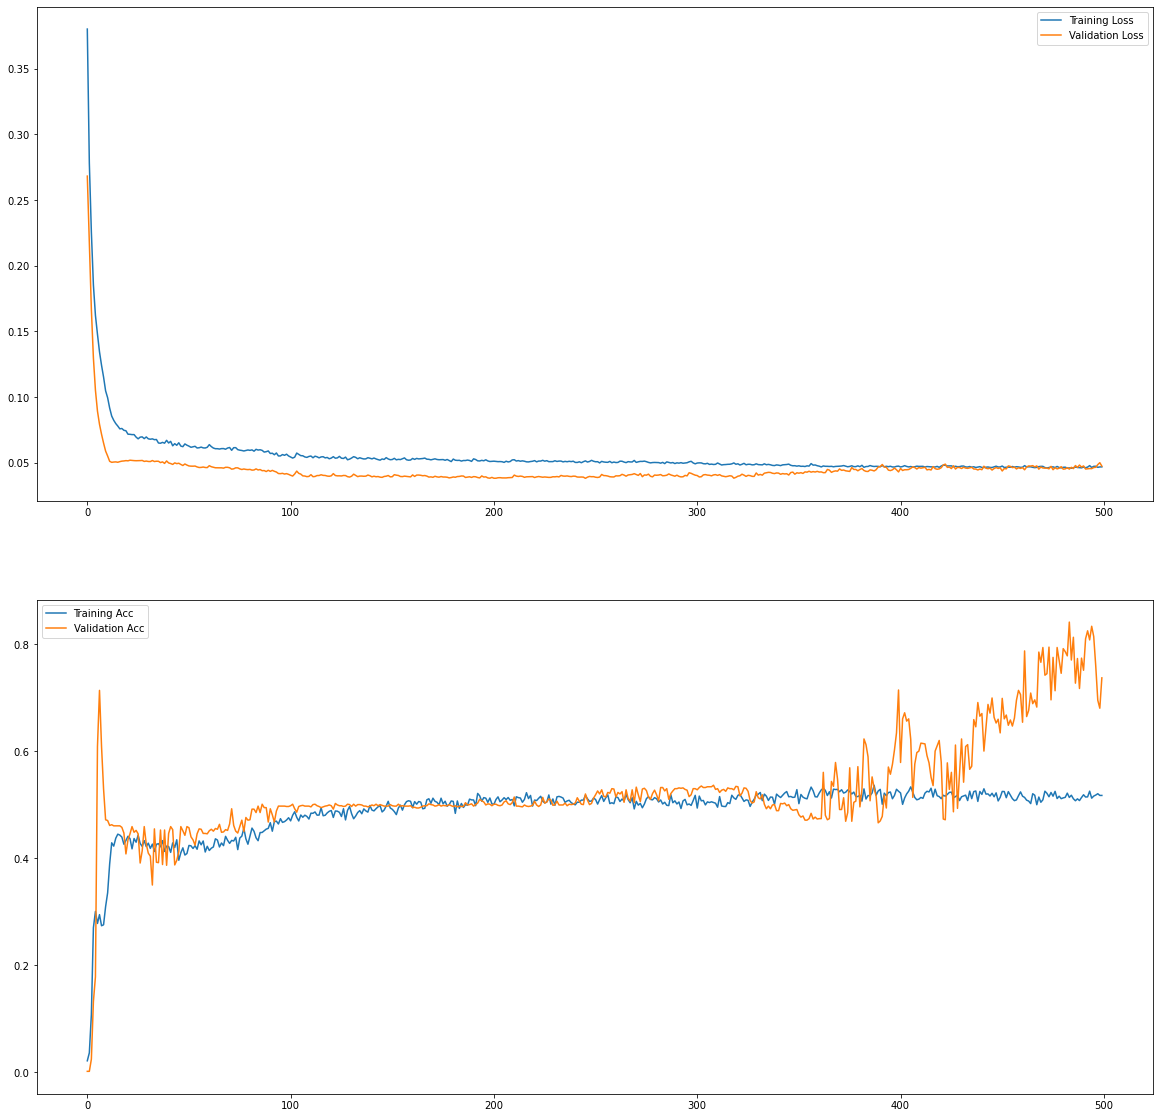

In [83]:
# 데이터 별 훈련결과 시각화
training_visualize(history)

In [84]:
def defective_decision(DAE, train_data, test_data):
    # 학습 데이터 예측값
    pred = DAE.predict(train_data)
    # 학습 데이터 복원 오차
    train_loss = np.mean(np.square(pred-train_data), axis=1)
    #임계치 (3시그마-99.7%)
    threshold = np.mean(train_loss) + 3*np.std(train_loss)

    # 평가 데이터
    # 예측값
    pred_def = DAE.predict(test_data)
    # 복원오차
    test_loss = np.mean(np.square(pred_def - test_data), axis=1)
    
    # colunm별 절대 오차
    colunm_error = np.abs(pred_def - test_data)

    defect = test_loss > threshold
    print("불량 개수: ", np.sum(defect))
    
    return defect, colunm_error

In [86]:
# 확인
print(f"테스트 데이터 개수: {len(test_df_Y)}")
test_df, test_CE = defective_decision(DAE, train_df, test_df_Y)

테스트 데이터 개수: 1761
불량 개수:  17


In [23]:
test_CE

array([[0.01069931, 0.02696654, 0.24183151, ..., 0.15505607, 0.24010849,
        0.05922645],
       [0.09011603, 0.21543648, 0.16049237, ..., 0.06902786, 0.23697007,
        0.26490161],
       [0.09738596, 0.14596001, 0.07110203, ..., 0.13936597, 0.26047167,
        0.04670724],
       ...,
       [0.08976312, 0.09645027, 0.17746719, ..., 0.0650375 , 0.2486891 ,
        0.08514875],
       [0.13624746, 0.06051579, 0.07751925, ..., 0.22146104, 0.26100534,
        0.09552007],
       [0.23464839, 0.03779539, 0.17210118, ..., 0.09793573, 0.26693157,
        0.05547401]])

In [24]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter]
CN7_650T_1st_refine = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME"], axis=1)
# 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
CN7_650T_1st_refine = CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] <= 0]
# CN7_650T_1st_refine.drop("ERR_FACT_QTY", axis=1, inplace=True)
# 학습을 위해 Time데이터 제거
CN7_650T_1st_refine.drop("TimeStamp", axis=1, inplace=True)

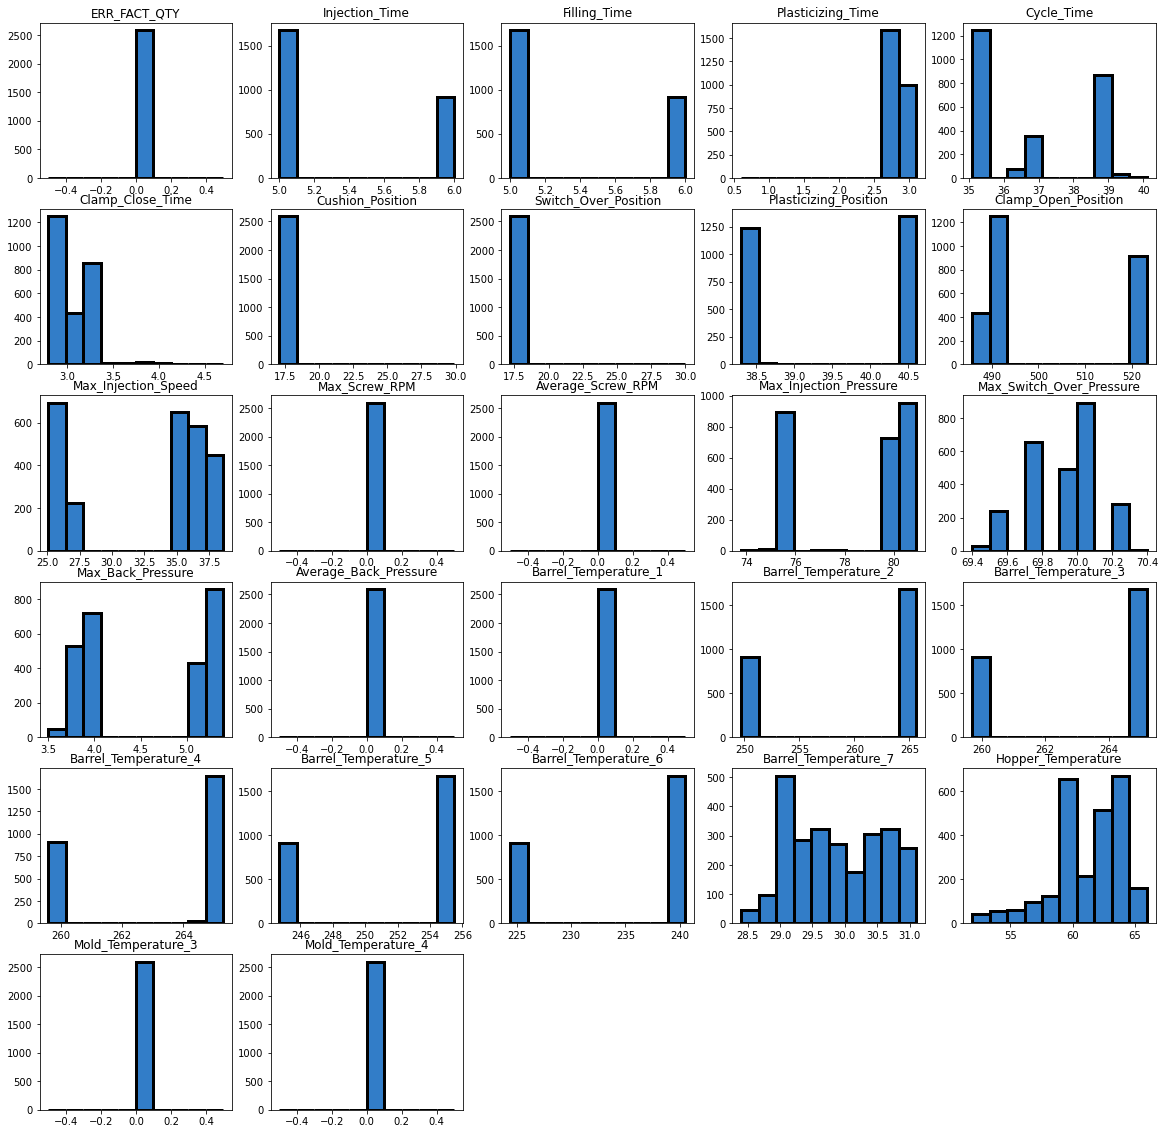

In [25]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] != 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

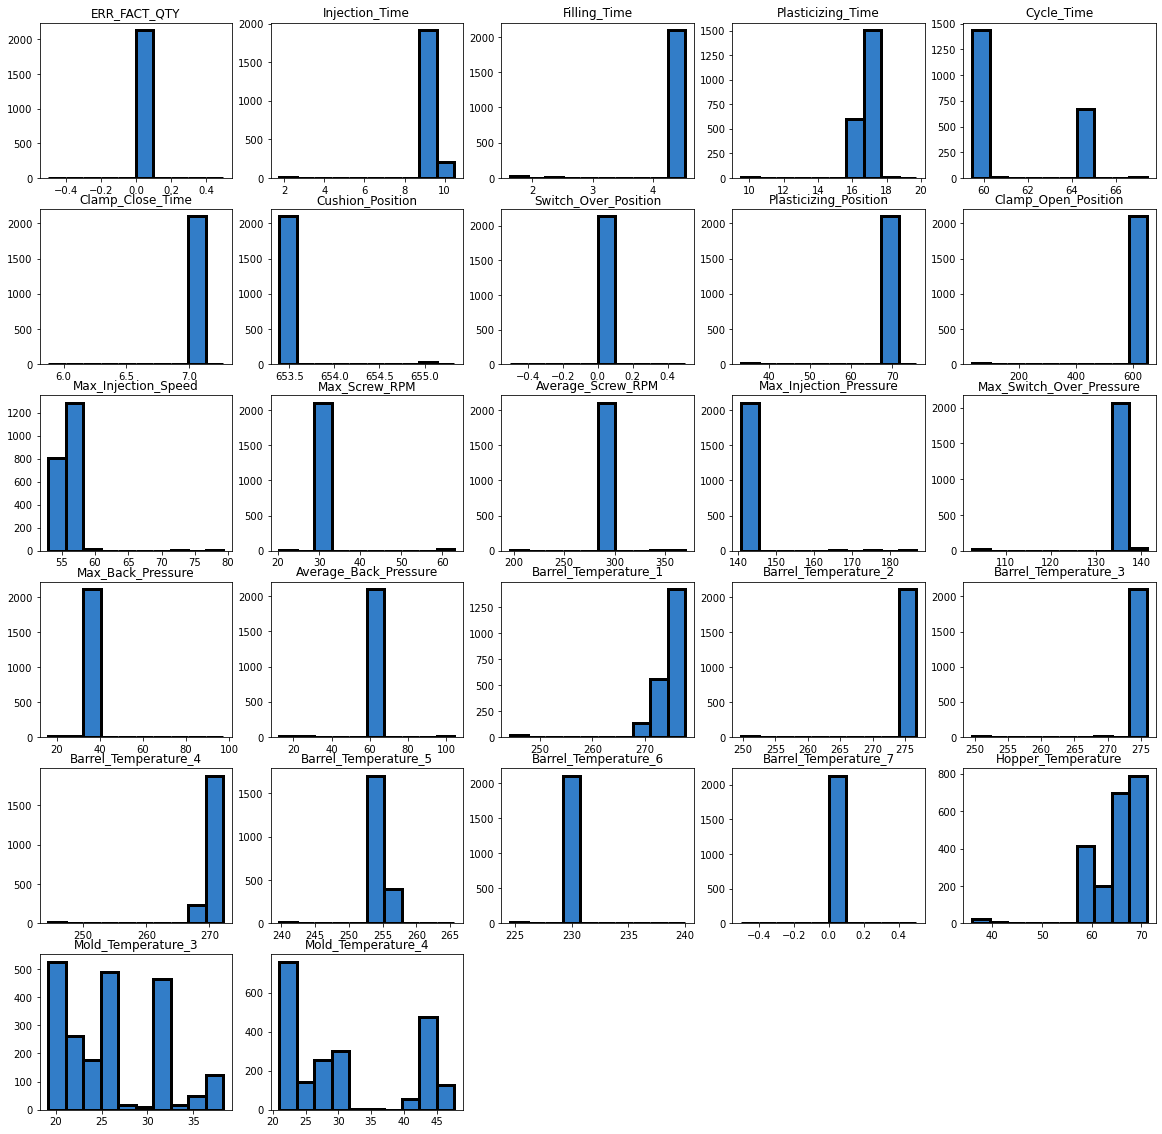

In [26]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [27]:
# 히스토그램 시각화
# test_df - 나누기 전

data = test_df[test_df["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([1])].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 히스토그램 시각화
visual_CN7_650T_1st_refine = CN7_650T_1st_refine.drop("TimeStamp", axis=1)
for index, value in enumerate(visual_CN7_650T_1st_refine):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(visual_CN7_650T_1st_refine[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)